In [1]:
import requests
import json
import getpass

# 1. Login to Neurohub through the API

In [ ]:
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json',
}
data = {
    'login': input('username'),
    'password': getpass.getpass('password')
}
response = requests.post('https://portal.cbrain.mcgill.ca/session', headers=headers, data=data)
if response.status_code == 200:
    print("Login success")
    print(response.content)
    jsonResponse = response.json()
    token = jsonResponse["cbrain_api_token"] #Token identifies your user session for you to use the API.
else:
    print("Login failure")

# 2. List files in the tutorial Data Provider

##### -Can set up data provider (DP) in NeuroHub by logging in, and clicking the 'Storage' button on the menu bar, followed by the green 'Create New Storage Configuration' button.
![image](storagePic.png)

##### -This set up a connection to a directory located on a remote server or workstation. If you can can SSH there, you can configure it as storage.
##### -So can use files on server, such as ComputeCanada, on Neurohub, instead of having to upload all files.
##### -We can list files in a DP and can find their file ID.
##### -I set up a DP for this tutorial with ID 369.

In [ ]:
dataprovider_ID = str(369)
headers = {
    'Accept': 'application/json',
}
params = (
    ('id', dataprovider_ID),
    ('cbrain_api_token', token),
)
url = 'https://portal.cbrain.mcgill.ca/data_providers/' + dataprovider_ID + '/browse'
response = requests.get(url, headers=headers, params=params, allow_redirects=True)
if response.status_code == 200:
    print(response.json())
else:
    print('DP browse failure')

# 3. Downloading Neurohub files through the API

##### Need file IDs from previous section to specify the file download

In [ ]:
fileID = str(3106143)

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
}
params = (
    ('cbrain_api_token', token),
)
data = {
  "file_ids": [ #Provide files ID strings as an array. If many files, will give compressed archive.
    fileID
  ]
}

# convert into JSON:
y = json.dumps(data)
response = requests.post('https://portal.cbrain.mcgill.ca/userfiles/download', headers=headers, params=params, data=y)
if response.status_code == 200:
    print(response.text)
    jsonResponse = response.json()
    print(jsonResponse)
else:
    print("Task posting failed.")

# 4. Working with the downloaded files

##### Can use the downloaded files with popular libraries such as nibabel and nilearn
##### Adapted from the nilearn examples at https://nilearn.github.io/auto_examples/index.html

In [ ]:
import sys
#install the packages we are using
!{sys.executable} -m pip install nibabel
!{sys.executable} -m pip install nilearn

In [2]:
import nibabel as nib #loads the brain scan files
from nilearn import plotting #For visualization

(176, 240, 256)
(64, 64, 32, 183)


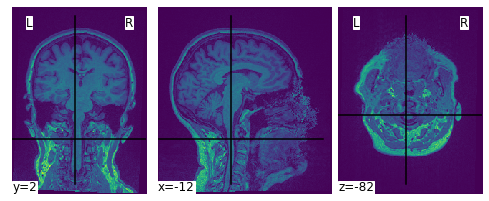

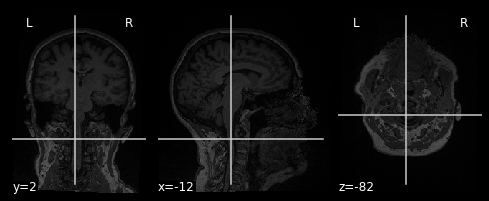

In [3]:
file_to_load = 'sub-1004359_ses-PREBL00_run-001_T1w.nii.gz' #specify filename as string
anat_file = nib.load(file_to_load) #loading an anatomical (T1 weighted) scan
print(anat_file.shape) #3D shape

file_to_load2 = 'sub-1004359_ses-PREBL00_task-encoding_run-001_bold.nii.gz'
bold_file = nib.load(file_to_load2) #loading an fMRI (BOLD) scan
print(bold_file.shape)#4D shape

plotting.plot_img(anat_file) #General purpose plotting, no specific preset
plotting.plot_anat(anat_file) #Anatomical image plotting

# 5. Smoothing

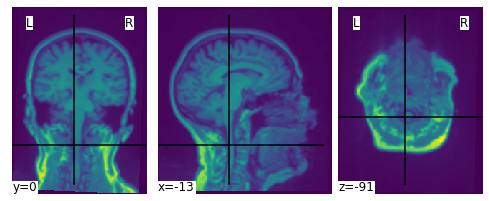

In [4]:
from nilearn import image
smooth_anat_img = image.smooth_img(anat_file, fwhm=3) #Apply a Gaussian filter along the three first dimensions of scan.
#fwhm parameter is the smoothing strength in mm
plotting.plot_img(smooth_anat_img) #General plotting function, compare to above.

# 6. fMRI visualization

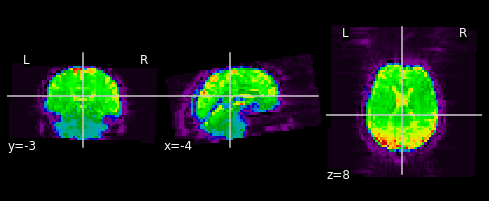

In [5]:
from nilearn.image.image import mean_img

mean_fmri = mean_img(bold_file) #Compute the mean of the images over time or the 4th dimension

from nilearn.plotting import plot_epi, show
plot_epi(mean_fmri) #plot cuts of the image (by default 3 cuts: Frontal, Axial, and Lateral)

# 7. Extract a brain mask

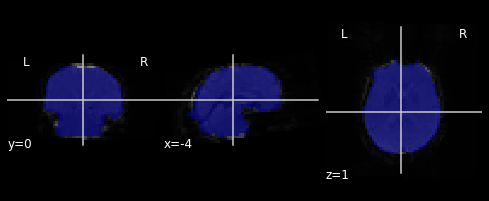

In [6]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(bold_file) #Compute a brain mask from fMRI data, 3D volume representing where object is within 3D space

# Visualize it as an ROI
from nilearn.plotting import plot_roi
plot_roi(mask_img, mean_fmri) #Plot cuts of an ROI/mask image (by default 3 cuts: Frontal, Axial, and Lateral)

# 8. Applying the mask to extract the corresponding time series

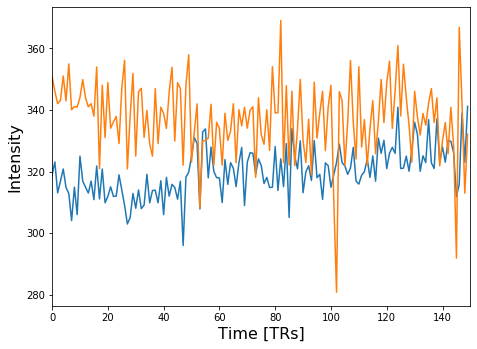

In [7]:
from nilearn.masking import apply_mask
masked_data = apply_mask(bold_file, mask_img) #Read the time series (extract signal) from the given Niimg-like object, using the mask.
#masked_data is in the form (timepoints, voxels).

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(masked_data[:150, :2]) #Plot first 150 timepoints from 2 voxels
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()

# 9. Independent component analysis (ICA) of fMRI
##### -Signal processing method to separate independent sources linearly mixed in several sensors
##### -Special case of blind source separation
##### -ICA will tell us to what degree each component contributes to the observed signal.

In [8]:
from nilearn.input_data import NiftiMasker

# Generate 3D mask to remove background
masker = NiftiMasker(smoothing_fwhm=8, memory='nilearn_cache', memory_level=1,
                     mask_strategy='epi', standardize=True)
data_masked = masker.fit_transform(bold_file)

In [9]:
from sklearn.decomposition import FastICA
n_components = 10
ica = FastICA(n_components=n_components, random_state=42)
components_masked = ica.fit_transform(data_masked.T).T

# Normalize estimated components, for thresholding to make sense
components_masked -= components_masked.mean(axis=0)
components_masked /= components_masked.std(axis=0)
# Threshold
import numpy as np
components_masked[np.abs(components_masked) < .8] = 0

# Invert the masking operation, to go back to a full 3D representation
component_img = masker.inverse_transform(components_masked)

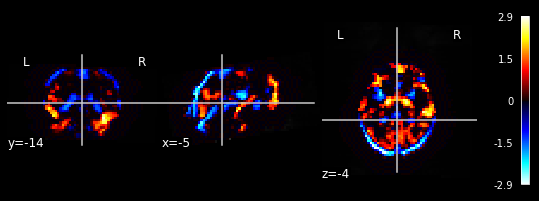

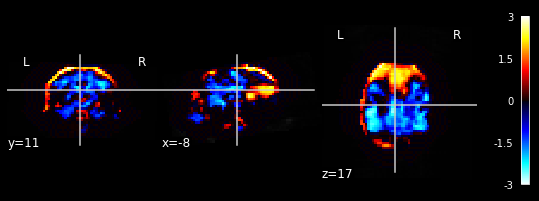

In [10]:
from nilearn import image
from nilearn.plotting import plot_stat_map, show

# Use the mean as a background
mean_img = image.mean_img(bold_file)

# Show some interesting components
plot_stat_map(image.index_img(component_img, 0), mean_img)
plot_stat_map(image.index_img(component_img, 1), mean_img)

show()